In [2]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<Axes: >

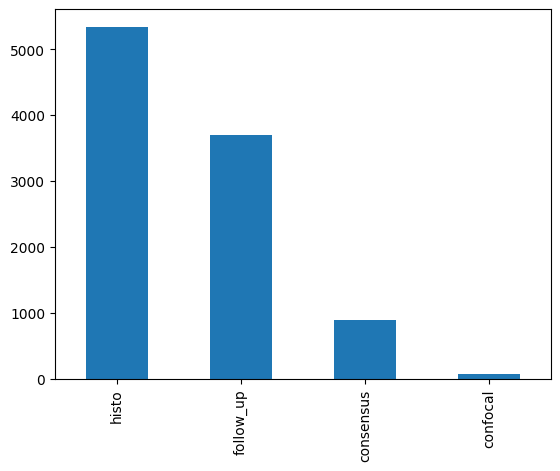

In [55]:
df = pd.read_csv('metadata.csv')
# df.dx.value_counts().plot(kind="bar")
df.dx_type.value_counts().plot(kind="bar")